In [ ]:
from pathlib import Path
drive_dir = Path("../")

import sys
import os
module_path = os.path.abspath(str(drive_dir))
sys.path.insert(0, module_path)

import pandas as pd


import seaborn as sns

import katspace
import katspace.core
import katspace.data
import katspace.plot


import importlib
for mod in ["katspace.core", "katspace.data", "katspace.plot"]:
    importlib.reload(sys.modules[mod])

from katspace.core import Corpus, Text, results_into_df, space_types_pos, space_types_pos_ext
from katspace.data import chunker, chunk_lengths
from katspace.plot import hist_heatmap as plot_hist_heatmap
from katspace.plot import plot_preprocess, plot_hist_preprocess

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from collections import Counter

import numpy as np
import math

#model_dir = Path(drive_dir, "Models/")

data_dir = Path(drive_dir, "data-test/")
results_dir = Path(data_dir, "results/predict-286-gutenberg/")

space_types = ("perceived_space", "action_space", "visual_space", "descriptive_space", "no_space")
notebooks_dir =  Path(drive_dir, "notebooks/")

In [6]:
def plot_hist(count_dict, chunk_sizes, title = "", fig = None, ax = None, bins = [20, 20], **kwargs):

    num_chunks = bins[0]

    x,y = plot_hist_preprocess(count_dict, chunk_sizes, num_chunks = num_chunks, debug_msg = title)
    ax.set_title(title)
    ax.set_xlabel("Narrative section")
    ax.set_ylabel("Frequency")
    ax.hist2d(x, y, bins = bins, **kwargs)


def plot_narrative_time_stats(results, num_chunks=20, plot_type = "histogram", space_types=("perceived_space", "action_space", "visual_space", "descriptive_space", "no_space"),
                                total=False, sum_sel=("perceived_space", "action_space", "visual_space", "descriptive_space")):

    count_dict, chunk_sizes = plot_preprocess(results, num_chunks, sum_sel)
    vert_num_chunks = 20

    if total == True:
      space_types = list(space_types) + ["all_space"]

    if plot_type == "histogram":
      #ToDo: Use new color scheme
      color = {"perceived_space": "Blues",
                "action_space": "Greens",
                "visual_space": "Reds",
                "descriptive_space": "GnBu",
                "no_space": "Greys",
                "all_space": 'Purples'
                }


      fig, axs = plt.subplots(ncols=1, nrows=len(space_types), figsize=(3, len(space_types) * 3),
                        layout="constrained") 

      for i, space_type in enumerate(space_types):
        plot_hist(count_dict[space_type], chunk_sizes, title = space_type, fig = fig, ax = axs[i], bins = [num_chunks, vert_num_chunks], cmap = color[space_type])

    elif plot_type == "violin":     
      fig, axs = plt.subplots(ncols=1, nrows=len(space_types), figsize=(10, len(space_types) * 6),
                        layout="constrained")
     # pos = range(1, num_chunks + 1)
      for i, space_type in enumerate(space_types):
        plot_violin(count_dict[space_type], chunk_sizes, num_chunks, title = space_type, fig = fig, ax = axs[i])
    
    elif plot_type == "lineplot":
      pass
    plt.show()
  
def non_empty_labels_from_iter(series):
  while True:
    next_element = next(series, "")
    if next_element == "":
      break
    else:
      yield next_element

In [ ]:
canon_df = pd.read_excel(Path(data_dir, "20240818_canon_master_merged.xlsx"))
non_fic_df = pd.read_excel(Path(data_dir, "20240816_non_fic_master.xlsx"), index_col = 0)
non_fic_df

In [10]:
#read parquet

from pandas.io.parquet import read_parquet
fp_labels_df = Path(data_dir, "results/2024_08_16_labels_df.parquet")
results_df = read_parquet(fp_labels_df)
results = {filename: list(non_empty_labels_from_iter(iter(results_df[filename]))) for filename in results_df.columns}

fp_labels_travel = Path(data_dir, "results/2025_01_21_labels_travelogues.parquet")
results_travel_df = read_parquet(fp_labels_travel)
results_travel = {filename: list(non_empty_labels_from_iter(iter(results_travel_df[filename]))) for filename in results_travel_df.columns}

fp_labels_nf = Path(data_dir, "results/2025_01_21_labels_non_fic_df.parquet")
results_nf_df = read_parquet(fp_labels_nf)

#non_fic_no_travel = [fn in results_nf_df.columns if fn not in results_travel_df.columns]
#results_nf = {filename: list(non_empty_labels_from_iter(iter(results_nf_df[filename]))) for filename in non_fic_no_travel}

In [11]:
non_fic_no_travel = [fn for fn in results_nf_df.columns if fn not in results_travel_df.columns]
results_nf = {filename: list(non_empty_labels_from_iter(iter(results_nf_df[filename]))) for filename in non_fic_no_travel}

In [20]:
def narrative_time_line_plot(num_chunks = 50, chunk_size = None, show_min = None, show_max = None, line_plot_opt_dict = None, 
                             results = None, space_types = space_types_pos_ext, legend = True): 
    if chunk_size == None:
        _num_chunks = num_chunks
    else:
        _num_chunks = None

    if line_plot_opt_dict == None:
            line_plot_opt_dict = {}
    
    if show_max:
        stop_before = show_max + 1
    else:
        stop_before = None

    sns.set_context("paper")
    sns.set_theme()
    sns.set_style("whitegrid")

    color_indexer = {'action_space': 1,
    'perceived_space': 0,
    'visual_space': 2,
    'descriptive_space': 3,
    'all_space': 4}

    _, axs = plt.subplots(ncols=1, nrows=len(space_types), figsize=(8, len(space_types) * 5),
                        layout="constrained")
    if len(space_types) <= 1: 
        axs = [axs]

    if type(results) != list: 
        results = [results]
        line_plot_opt_dict = [line_plot_opt_dict]
    if line_plot_opt_dict == {} and len(results) > 1:
        line_plot_opt_dict = [{}] * len(results) 



    plot_data = [
        plot_preprocess(result_dict, num_chunks=_num_chunks, sum_sel=space_types_pos, 
                                                        start_at = show_min, stop_before=stop_before, chunk_size=chunk_size)
        for result_dict in results
    ] 
              
    for ax, space_type in zip(axs, space_types):

        ax.set_title(space_type)
        ax.set_xlabel("Narrative section")
        ax.set_ylabel("Frequency")
        ax.set_xmargin(0)

        for (count_dict, chunk_sizes), opt in zip(plot_data, line_plot_opt_dict):
            if space_type in opt.keys():
                space_type_opt = opt.pop(space_type) 
            else: 
                space_type_opt = {}
            opt = {k:v for k, v in opt.items() if k not in space_types_pos_ext}
            x,y = plot_hist_preprocess(count_dict[space_type], chunk_sizes, start_at=show_min, debug_msg = space_type)
            ax.set_xticks(range(min(x), max(x)+1))
            sns.lineplot(x = x, y = y, ax = ax, **opt, **space_type_opt) 
        
        ax.get_legend().set_visible(legend)

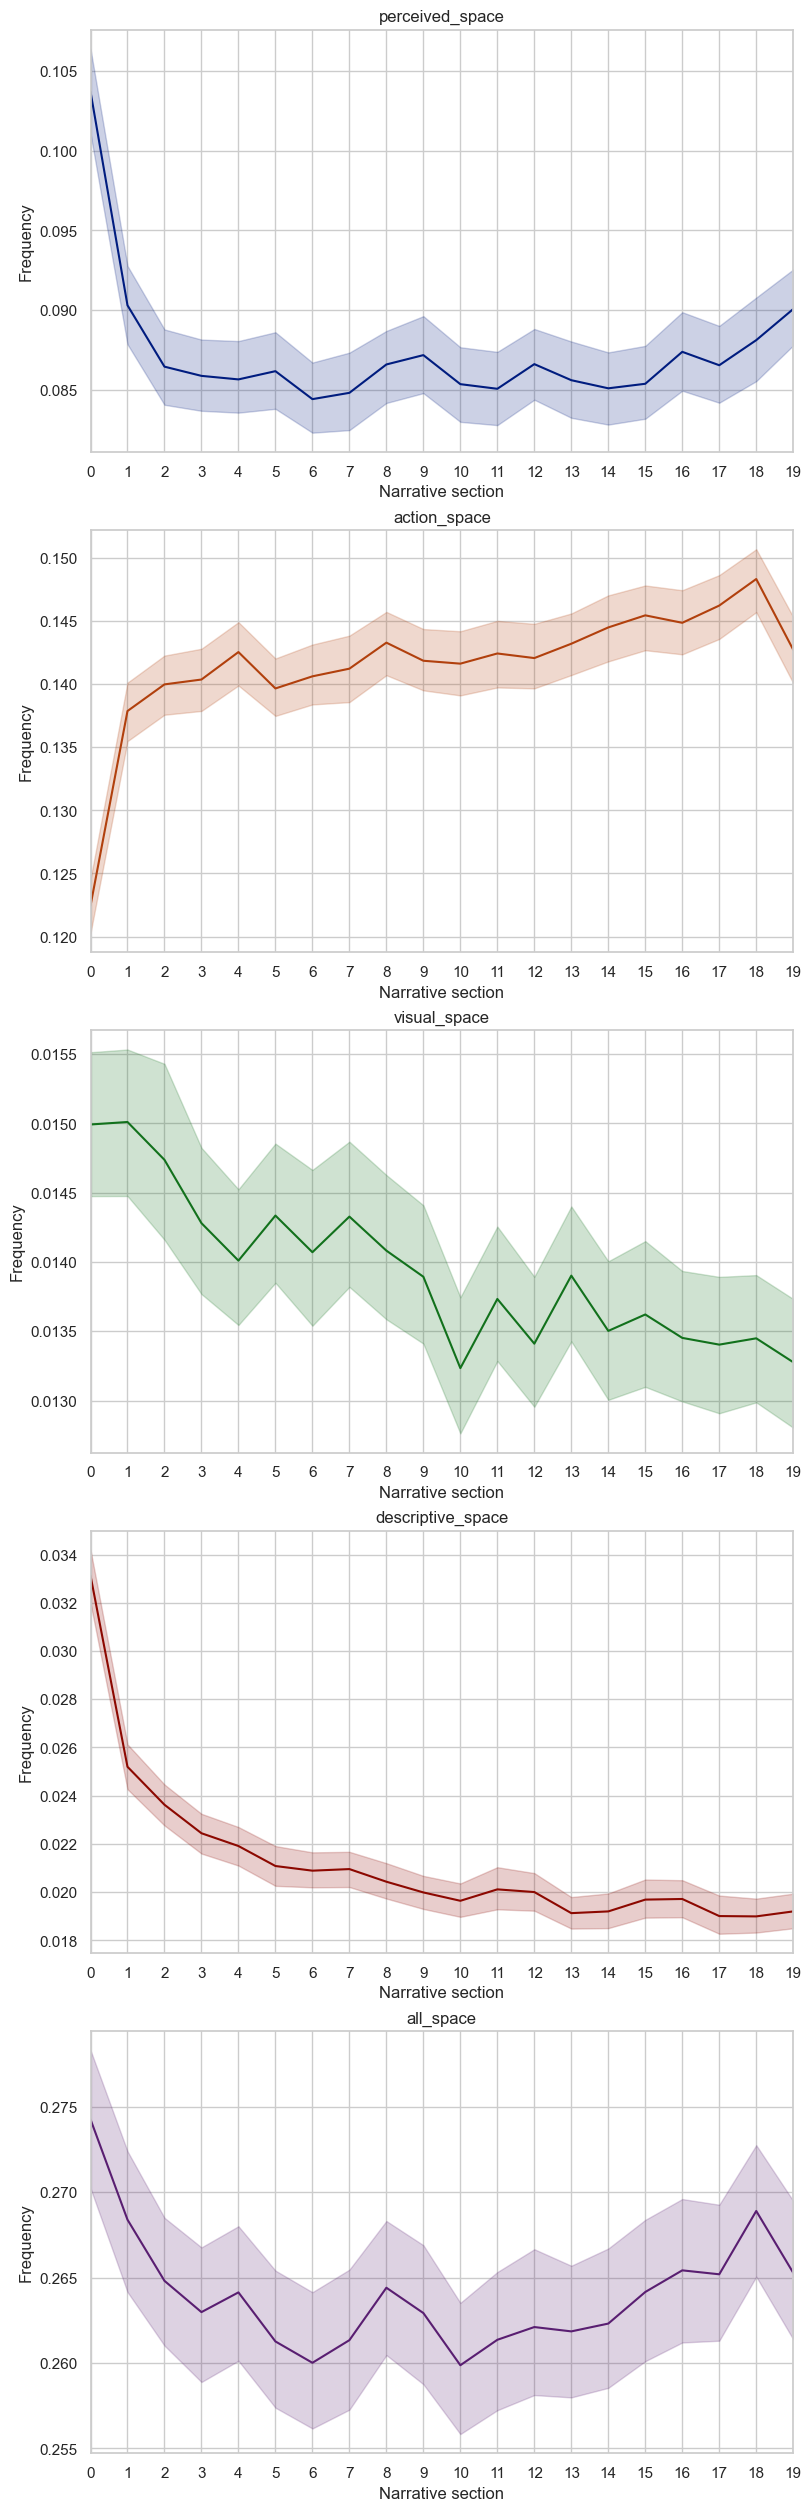

In [26]:
color_indexer = {'action_space': 1,
 'perceived_space': 0,
 'visual_space': 2,
 'descriptive_space': 3,
 'all_space': 4}

palettes = {space_type : [sns.color_palette(name).as_hex()[i] for name in ["dark", "pastel", "bright"]] for space_type, i in color_indexer.items()}
palettes

opt = [
     {"label" :  "fiction", 
     "dashes" : False},
    {"label" : "travelogues", 
     "dashes" : True}, 
    {"label" :  "non-fiction", 
     "dashes" : False}
]

for space_type in space_types_pos_ext: 
    for o, palette in zip(opt, palettes[space_type]): 
        o[space_type] = {"color" : palette}


narrative_time_line_plot(results = [results], num_chunks = 20, chunk_size = None, show_max= None, 
                            line_plot_opt_dict = opt, legend=False)

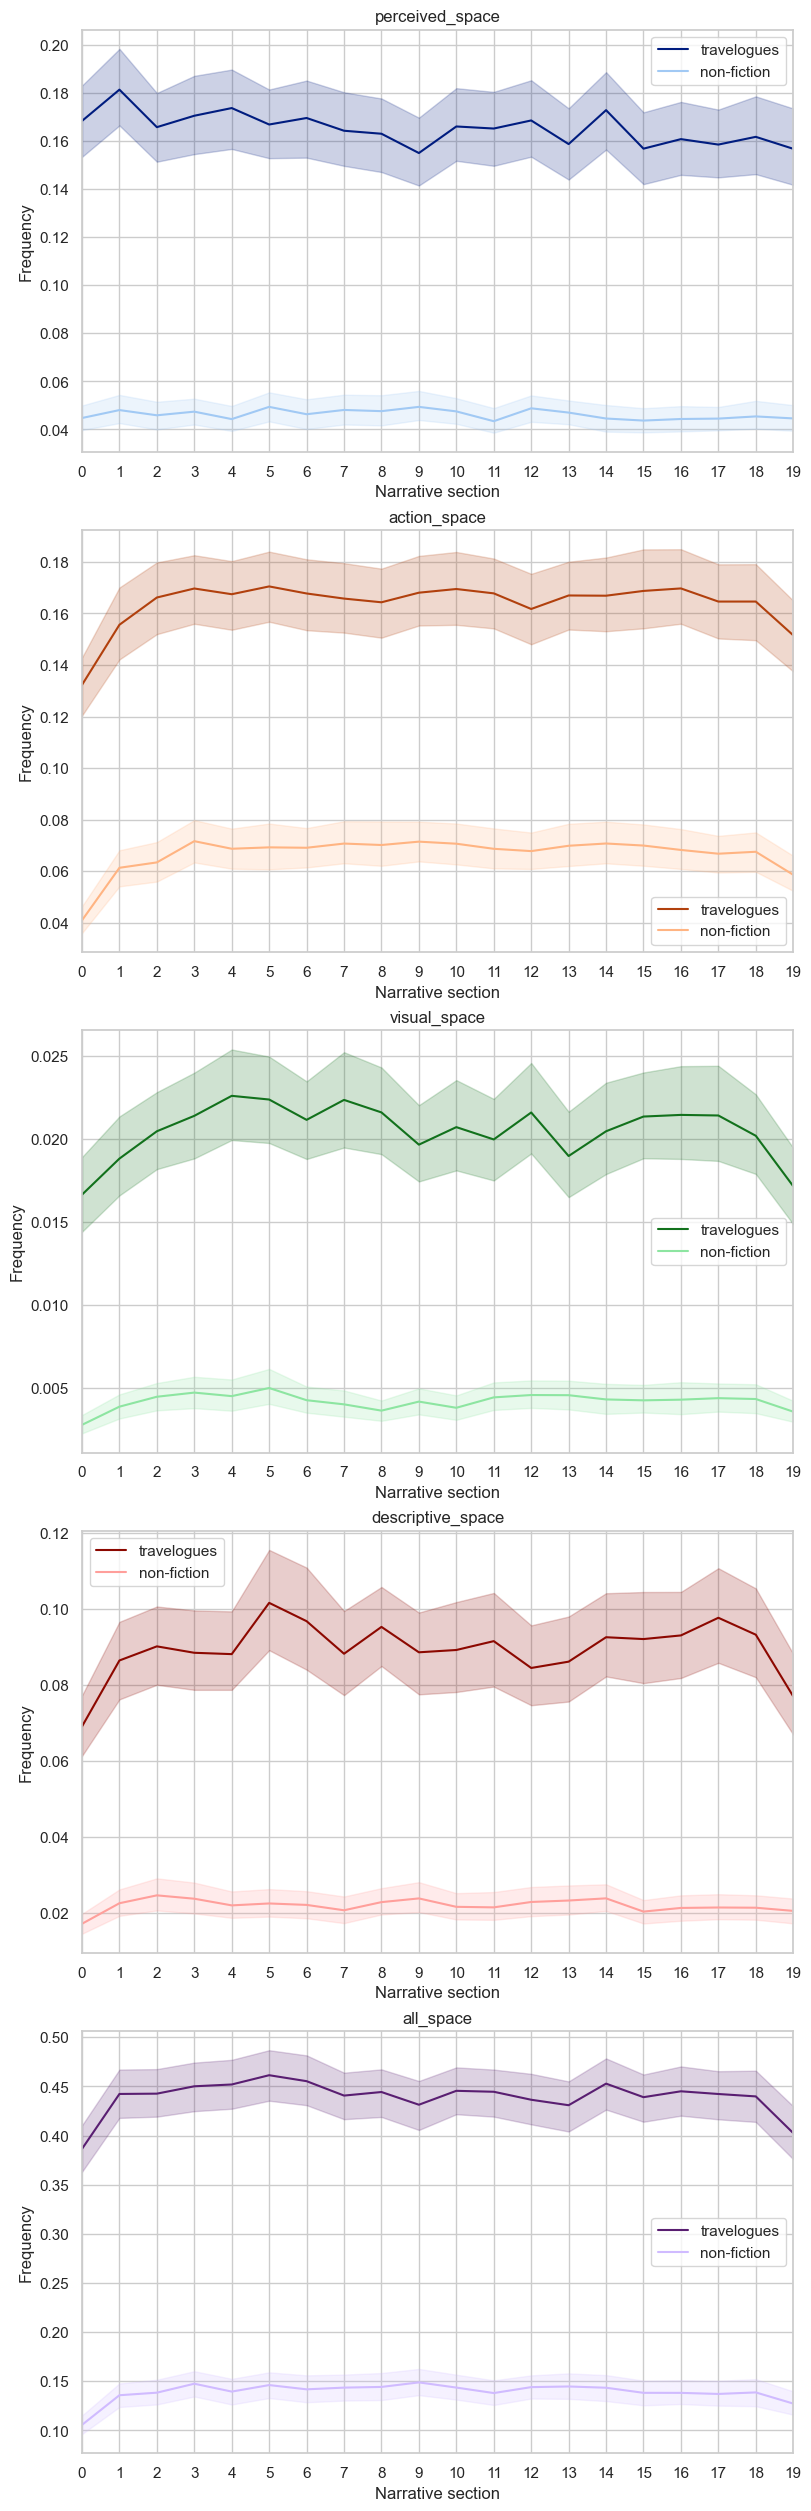

In [ ]:
color_indexer = {'action_space': 1,
 'perceived_space': 0,
 'visual_space': 2,
 'descriptive_space': 3,
 'all_space': 4}

palettes = {space_type : [sns.color_palette(name).as_hex()[i] for name in ["dark", "pastel", "bright"]] for space_type, i in color_indexer.items()}
palettes

opt = [
    {"label" : "travelogues", 
     "dashes" : True}, 
    {"label" :  "non-fiction", 
     "dashes" : False}, 
     {"label" :  "fiction", 
     "dashes" : False}
]

for space_type in space_types_pos_ext: 
    for o, palette in zip(opt, palettes[space_type]): 
        o[space_type] = {"color" : palette}

narrative_time_line_plot(results = [results_travel, results_nf], num_chunks = 20, chunk_size = None, show_max= None, 
                            line_plot_opt_dict = opt)